> E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

With context size `4`, embedding size `15`, and dynamic learning rate (`0.5` for 1~5000 epochs and `0.1` for 5001~25000 epochs), the validation loss was get down to `2.19` 😨

|  | train | test | dev |
| --- | --- | --- | --- |
| reproduce | `2.1644` | `2.2246` | `2.2191` |
| tuned | `2.1457` | `2.1999` | `2.1951` |

> E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

(1) If the model predicts uniform probabilities as output, its loss should be:

|  | train | test | dev |
| --- | --- | --- | --- |
| tuned | `3.2958` | `3.2958` | `3.2958` |

(2) There are two approaches to initialized the model to output uniform probabilities: (a) Zero value weights and bias. (b) Zero value embeddings and bias. There performances are:

|  | train | test | dev |
| --- | --- | --- | --- |
| approach (a) | `2.8226` | `2.8270` | `2.8196` |
| approach (b) | `2.2122` | `2.2305` | `2.2233` |

Results shown that both approach is worse than randomly initialize all parameters. Among them, (b) works much better than (a).

> E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [2]:
import torch

if torch.backends.mps.is_available():
    # not sure why, the mps device is even slower than the cpu device on my MacBook m1 machine
    # device = torch.device('mps')
    device = torch.device('cpu')
else:
    device = torch.device('cpu')

device

device(type='cpu')

# Load data

In [3]:
words = open('../../../data/names.txt', 'r').read().splitlines()

In [4]:
g = torch.Generator().manual_seed(2147483647)
trainwords, devwords, testwords = torch.utils.data.random_split(words, [0.8, 0.1, 0.1])

In [5]:
class Dataset:
    def __init__(self, dataset, context_size: int = 3):
        # create character - index mapping
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        # digitize the dataset
        xs, ys = [], []

        for w in dataset:
            context = [0] * context_size

            for ch in w + '.':
                ix = self.stoi[ch]
                xs.append(context)
                ys.append(ix)
                context = context[1:] + [ix]

        self.xs = torch.tensor(xs, device=device)
        self.ys = torch.tensor(ys, device=device)

    def __len__(self):
        return len(self.xs)
    
    def draw(self, batch_size: int = 32):
        ix = torch.randint(0, len(self), (batch_size,))
        return(self.xs[ix], self.ys[ix])

In [14]:
trainset = Dataset(trainwords)
devset = Dataset(devwords)
testset = Dataset(testwords)

# Multilayer perceptron

In [6]:
import sys

def progress_bar(percent: float, bar_len: int = 20, front_str: str = '', back_str: str = ''):
    sys.stdout.write("\r")
    sys.stdout.write("{}[{:<{}}] {:.1%}{}".format(front_str, "=" * int(bar_len * percent), bar_len, percent, back_str))
    sys.stdout.flush()
    # avoiding '%' appears when progress completed
    if percent == 1:
        print()

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def loss_curve(loss_ls):
    plt.plot(np.reshape(loss_ls, (-1,)))
    plt.xlabel('epoch')
    plt.ylabel('cross entropy')
    plt.grid('--')

In [8]:
import torch.nn.functional as F

class MLP_LM:
    def __init__(self, context_size: int = 3, embed_size: int = 10, hidden_size: int = 200):
        self.input_size = context_size * embed_size

        g = torch.Generator().manual_seed(2147483647)

        self.C = torch.randn((27, embed_size), generator=g).to(device)
        self.W1 = torch.randn((self.input_size, hidden_size), generator=g).to(device)
        self.b1 = torch.randn((hidden_size), generator=g).to(device)
        self.W2 = torch.randn((hidden_size, 27), generator=g).to(device)
        self.b2 = torch.randn((27), generator=g).to(device)
        self.param = [self.C, self.W1, self.W2, self.b1, self.b2]

    def forward(self, xs):
        emb = self.C[xs]
        h = torch.tanh(emb.view(-1, self.input_size) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def train(self, dataset, batch_size: int = 32, epochs: int = 10, lr: float = 1e-1):
        for p in self.param:
            p.requires_grad = True

        loss_ls = []

        for ix in range(epochs):
            progress_bar((ix+1) / epochs, back_str="\t learning rate {}".format(lr))

            # batch forward/backward pass
            xs_batch, ys_batch = dataset.draw(batch_size)
            logits = self.forward(xs_batch)
            loss = F.cross_entropy(logits, ys_batch)
            loss_ls.append(loss.item())

            # gradient descent
            for p in self.param:
                p.grad = None
            
            loss.backward()

            for p in self.param:
                p.data += -lr * p.grad

        return loss_ls

    def eval(self, dataset, loss_str: str = ''):
        xs, ys = dataset.xs, dataset.ys
        logits = self.forward(xs)
        loss = F.cross_entropy(logits, ys)
        print("{} \t {:.4f}".format(loss_str, loss.item()))

# Uniform probabilities

In [23]:
class LM_up(MLP_LM):
    def forward(self, xs):
        return torch.zeros((len(xs), 27))

In [24]:
lm = LM_up()
lm.eval(trainset, loss_str='train')
lm.eval(devset, loss_str='dev')
lm.eval(testset, loss_str='test')

train 	 3.2958
dev 	 3.2958
test 	 3.2958


# Uniform probabilities initialization (a)

Zero value weights and bias at initialization

In [26]:
class MLP_LM_upi(MLP_LM):
    def __init__(self, context_size: int = 3, embed_size: int = 10, hidden_size: int = 200):
        self.input_size = context_size * embed_size

        g = torch.Generator().manual_seed(2147483647)

        self.C = torch.randn((27, embed_size), generator=g).to(device)
        self.W1 = torch.zeros((self.input_size, hidden_size)).to(device)
        self.b1 = torch.zeros((hidden_size)).to(device)
        self.W2 = torch.zeros((hidden_size, 27)).to(device)
        self.b2 = torch.zeros((27)).to(device)
        self.param = [self.C, self.W1, self.W2, self.b1, self.b2]

In [31]:
lm = MLP_LM_upi()
lm.eval(trainset, loss_str='train')
lm.eval(devset, loss_str='dev')
lm.eval(testset, loss_str='test')

train 	 3.2958
dev 	 3.2958
test 	 3.2958


[====================] 100.0%	 learning rate 0.5
train 	 2.8227
dev 	 2.8271
test 	 2.8198
[====================] 100.0%	 learning rate 0.1
train 	 2.8226
dev 	 2.8270
test 	 2.8197
[====================] 100.0%	 learning rate 0.1
train 	 2.8226
dev 	 2.8269
test 	 2.8197
[====================] 100.0%	 learning rate 0.1
train 	 2.8226
dev 	 2.8269
test 	 2.8197
[====================] 100.0%	 learning rate 0.1
train 	 2.8226
dev 	 2.8270
test 	 2.8196


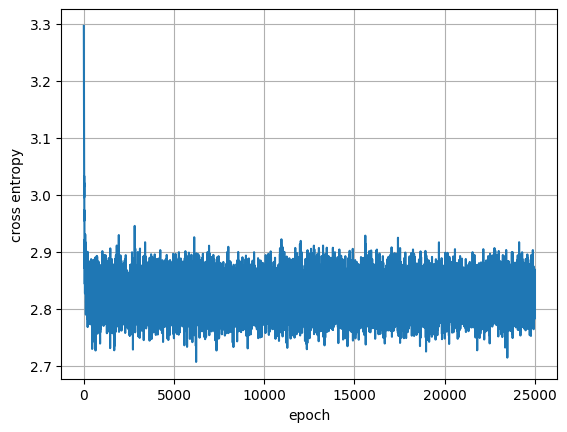

In [28]:
loss_ls = []

for lr in [5e-1, 1e-1, 1e-1, 1e-1, 1e-1]:
    loss_ls.append(lm.train(trainset, epochs=5000, batch_size=1000, lr=lr))
    
    # eval
    lm.eval(trainset, loss_str='train')
    lm.eval(devset, loss_str='dev')
    lm.eval(testset, loss_str='test')

loss_curve(loss_ls)

# Uniform probabilities initialization (b)

Zero value embeddings and bias at initialization.

In [35]:
class MLP_LM_upi_c(MLP_LM):
    def __init__(self, context_size: int = 3, embed_size: int = 10, hidden_size: int = 200):
        self.input_size = context_size * embed_size

        g = torch.Generator().manual_seed(2147483647)

        self.C = torch.zeros((27, embed_size)).to(device)
        self.W1 = torch.randn((self.input_size, hidden_size), generator=g).to(device)
        self.b1 = torch.zeros((hidden_size)).to(device)
        self.W2 = torch.randn((hidden_size, 27), generator=g).to(device)
        self.b2 = torch.zeros((27)).to(device)
        self.param = [self.C, self.W1, self.W2, self.b1, self.b2]

In [36]:
lm = MLP_LM_upi_c()
lm.eval(trainset, loss_str='train')
lm.eval(devset, loss_str='dev')
lm.eval(testset, loss_str='test')

train 	 3.2958
dev 	 3.2958
test 	 3.2958


[====================] 100.0%	 learning rate 0.5
train 	 2.9232
dev 	 2.9272
test 	 2.9262
[====================] 100.0%	 learning rate 0.1
train 	 2.2375
dev 	 2.2511
test 	 2.2434
[====================] 100.0%	 learning rate 0.1
train 	 2.2299
dev 	 2.2450
test 	 2.2389
[====================] 100.0%	 learning rate 0.1
train 	 2.2188
dev 	 2.2354
test 	 2.2267
[====================] 100.0%	 learning rate 0.1
train 	 2.2122
dev 	 2.2305
test 	 2.2233


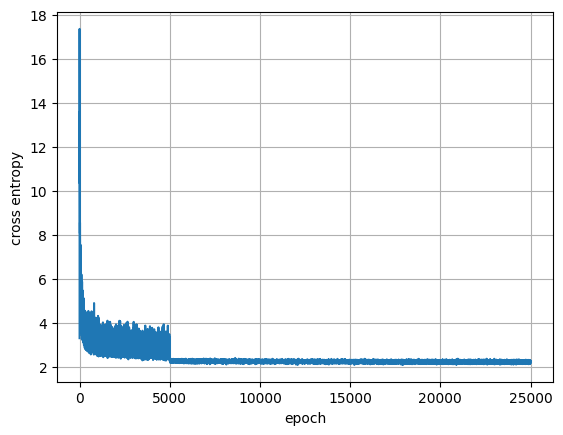

In [37]:
lm = MLP_LM_upi_c()

# train
loss_ls = []

for lr in [5e-1, 1e-1, 1e-1, 1e-1, 1e-1]:
    loss_ls.append(lm.train(trainset, epochs=5000, batch_size=1000, lr=lr))
    
    # eval
    lm.eval(trainset, loss_str='train')
    lm.eval(devset, loss_str='dev')
    lm.eval(testset, loss_str='test')

loss_curve(loss_ls)